In [50]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [ ]:
import os
import time
import json
import requests

# ─── CONFIG ──────────────────────────────────────────────────────────────

CLIENT_ID     = os.getenv("EBAY_PROD_CLIENT_ID", "your-client-id")
CLIENT_SECRET = os.getenv("EBAY_PROD_CLIENT_SECRET", "your-client-secret")

TOKEN_URL     = "https://api.ebay.com/identity/v1/oauth2/token"
SCOPE         = "https://api.ebay.com/oauth/api_scope"
SEARCH_URL    = "https://api.ebay.com/buy/browse/v1/item_summary/search"
DETAILS_URL   = "https://api.ebay.com/buy/browse/v1/item/"

PAGE_SIZE = 100
PAGES = 20  # 20 * 100 = 2000 items per category

categories = {
    "15032": "Laptops",
    "15052": "Tablets",
    "111422": "Headphones",
    "11116": "Cameras",
    "11189": "Televisions",
    "11124": "Consoles",
    "175673": "Smart Watches",
    "293": "General Electronics"
}

_token_cache = {"access_token": None, "expires_at": 0.0}

# ─── AUTH ────────────────────────────────────────────────────────────────

def get_token():
    now = time.time()
    if _token_cache["access_token"] and now < _token_cache["expires_at"] - 30:
        return _token_cache["access_token"]
    resp = requests.post(
        TOKEN_URL,
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        auth=(CLIENT_ID, CLIENT_SECRET),
        data={"grant_type": "client_credentials", "scope": SCOPE}
    )
    resp.raise_for_status()
    data = resp.json()
    _token_cache["access_token"] = data["access_token"]
    _token_cache["expires_at"] = now + data["expires_in"]
    return _token_cache["access_token"]

def safe_get(url, headers, params=None, retries=5):
    for attempt in range(retries):
        resp = requests.get(url, headers=headers, params=params)
        if resp.status_code == 429:
            wait = 2 ** attempt
            print(f"⏳ Rate limited. Retrying in {wait}s...")
            time.sleep(wait)
            continue
        resp.raise_for_status()
        return resp
    raise Exception("Too many 429s")

# ─── FETCH FUNCTIONS ─────────────────────────────────────────────────────

def fetch_items(cat_id, offset):
    token = get_token()
    return safe_get(
        SEARCH_URL,
        headers={"Authorization": f"Bearer {token}", "Content-Type": "application/json"},
        params={"category_ids": cat_id, "limit": PAGE_SIZE, "offset": offset}
    ).json().get("itemSummaries", [])

def fetch_item_details(item_id):
    token = get_token()
    try:
        resp = safe_get(f"{DETAILS_URL}{item_id}", headers={
            "Authorization": f"Bearer {token}",
            "Content-Type": "application/json"
        })
        data = resp.json()
        return {
            "localizedAspects": data.get("localizedAspects", {}),
            "description": data.get("description", "")
        }
    except Exception as e:
        print(f"Details failed for {item_id}: {e}")
        return {}

# ─── PER CATEGORY PROCESSOR ──────────────────────────────────────────────

def fetch_category(category_id, category_name, output_dir="output"):
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{category_name.replace(' ', '_').lower()}.jsonl")
    total = 0
    with open(output_file, "w") as fout:
        for page in range(PAGES):
            offset = page * PAGE_SIZE
            try:
                batch = fetch_items(category_id, offset)
            except Exception as e:
                print(f"❌ Failed batch at offset {offset}: {e}")
                break

            if not batch:
                break

            for item in batch:
                enriched = fetch_item_details(item["itemId"])
                item.update(enriched)
                fout.write(json.dumps(item) + "\n")
                fout.flush()
                total += 1
                print(f"✔ [{category_name}] {total}: {item['title'][:60]}")
                time.sleep(1.0)
    print(f"\n✅ Finished {category_name}: {total} items saved to {output_file}")
    return output_file

# ─── MAIN RUNNER ─────────────────────────────────────────────────────────

def main():
    for cat_id, name in categories.items():
        print(f"\n📦 Starting: {name}")
        fetch_category(cat_id, name)
        print("🛌 Cooling down 60s before next category...")
        time.sleep(60)  # cooldown between categories

    print("\n🎉 All categories complete. You can combine files with:")
    print("cat output/*.jsonl > ebay_enriched_items.jsonl")

if __name__ == "__main__":
    main()


In [1]:
import os
import json

input_folder = 'data'
output_file = 'combined.jsonl'

with open(output_file, 'w', encoding='utf-8') as outfile:
    for filename in os.listdir(input_folder):
        if filename.endswith('.jsonl'):
            file_path = os.path.join(input_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as infile:
                for line in infile:
                    outfile.write(line)


In [2]:
import pandas as pd

# Load the first 20 records from your raw eBay JSONL file
df = pd.read_json('combined.jsonl', lines=True, nrows=10)
df.head(10)

itemId  \
0             v1|226736633219|0   
1             v1|234702350191|0   
2             v1|234725338124|0   
3             v1|232090380033|0   
4             v1|127133794717|0   
5             v1|376133027549|0   
6             v1|146605783447|0   
7             v1|176846683687|0   
8  v1|146460265518|445245545286   
9             v1|365274074621|0   

                                               title leafCategoryIds  \
0  Apple 16 Inch MacBook Pro 2019/2021 32GB RAM 5...        [111422]   
1  Apple MacBook Pro 15" 16GB i7 3.7Ghz - Retina ...        [111422]   
2  13" Apple MacBook Air 512gb SSD 8gb 3.2Ghz i7 ...        [111422]   
3  13" Apple MacBook Air Big Sur 3.3Ghz i7 TURBO ...        [111422]   
4  Apple - MacBook Air 15inch Apple M4 chip  - 16...        [111422]   
5  Apple M1 Pro MacBook Pro 14" 16GB 1TB - A2442 ...        [111422]   
6  13 Inch MacBook Air M3 Chip 256GB SSD Midnight...        [111422]   
7  Apple MacBook Pro 15.4-Inch Intel Core i9, 32G...        [111422]   
8  Apple MacBook Pro M3 Pro 14.2" 11-CoreCPU 14-C...        [111422]   
9  Apple MacBook Pro 14" Apple M4 chip 16GB RAM 5...        [111422]   

                                          categories  \
0  [{'categoryId': '111422', 'categoryName': 'App...   
1  [{'categoryId': '111422', 'categoryName': 'App...   
2  [{'categoryId': '111422', 'categoryName': 'App...   
3  [{'categoryId': '111422', 'categoryName': 'App...   
4  [{'categoryId': '111422', 'categoryName': 'App...   
5  [{'categoryId': '111422', 'categoryName': 'App...   
6  [{'categoryId': '111422', 'categoryName': 'App...   
7  [{'categoryId': '111422', 'categoryName': 'App...   
8  [{'categoryId': '111422', 'categoryName': 'App...   
9  [{'categoryId': '111422', 'categoryName': 'App...   

                                               image  \
0  {'imageUrl': 'https://i.ebayimg.com/images/g/w...   
1  {'imageUrl': 'https://i.ebayimg.com/images/g/5...   
2  {'imageUrl': 'https://i.ebayimg.com/images/g/e...   
3  {'imageUrl': 'https://i.ebayimg.com/images/g/a...   
4  {'imageUrl': 'https://i.ebayimg.com/images/g/g...   
5  {'imageUrl': 'https://i.ebayimg.com/images/g/2...   
6  {'imageUrl': 'https://i.ebayimg.com/images/g/N...   
7  {'imageUrl': 'https://i.ebayimg.com/images/g/t...   
8  {'imageUrl': 'https://i.ebayimg.com/images/g/j...   
9  {'imageUrl': 'https://i.ebayimg.com/images/g/T...   

                                     price  \
0   {'value': '725.00', 'currency': 'USD'}   
1   {'value': '475.00', 'currency': 'USD'}   
2   {'value': '329.00', 'currency': 'USD'}   
3   {'value': '319.00', 'currency': 'USD'}   
4   {'value': '750.00', 'currency': 'USD'}   
5   {'value': '879.99', 'currency': 'USD'}   
6   {'value': '650.00', 'currency': 'USD'}   
7   {'value': '459.00', 'currency': 'USD'}   
8  {'value': '1189.00', 'currency': 'USD'}   
9  {'value': '1249.00', 'currency': 'USD'}   

                                            itemHref  \
0  https://api.ebay.com/buy/browse/v1/item/v1%7C2...   
1  https://api.ebay.com/buy/browse/v1/item/v1%7C2...   
2  https://api.ebay.com/buy/browse/v1/item/v1%7C2...   
3  https://api.ebay.com/buy/browse/v1/item/v1%7C2...   
4  https://api.ebay.com/buy/browse/v1/item/v1%7C1...   
5  https://api.ebay.com/buy/browse/v1/item/v1%7C3...   
6  https://api.ebay.com/buy/browse/v1/item/v1%7C1...   
7  https://api.ebay.com/buy/browse/v1/item/v1%7C1...   
8  https://api.ebay.com/buy/browse/v1/item/v1%7C1...   
9  https://api.ebay.com/buy/browse/v1/item/v1%7C3...   

                                              seller  \
0  {'username': 'alpha_tech_store', 'feedbackPerc...   
1  {'username': 'payless4apple', 'feedbackPercent...   
2  {'username': 'payless4apple', 'feedbackPercent...   
3  {'username': 'payless4apple', 'feedbackPercent...   
4  {'username': 'blissco25', 'feedbackPercentage'...   
5  {'username': 'tekdeals', 'feedbackPercentage':...   
6  {'username': 'hemostasis', 'feedbackPercentage...   
7  {'username': 'dutyfreewholesale', 'fe

In [3]:
import pandas as pd
import json
import re
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load your combined JSONL file
combined_file_path = "combined.jsonl"
items = []
with open(combined_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            items.append(json.loads(line))
        except json.JSONDecodeError:
            continue

# Feature extraction function
def extract_features(item):
    raw_description = item.get("description", "")
    description_text = BeautifulSoup(raw_description, "html.parser").get_text().lower()

    # Keyword flags from description
    keywords = ["new", "used", "refurbished", "warranty", "free shipping", "mint", "sealed", "genuine", "authentic"]
    keyword_flags = {f"desc_has_{kw.replace(' ', '_')}": int(kw in description_text) for kw in keywords}
    keyword_flags["desc_year_mentions"] = len(re.findall(r'\b(19|20)\d{2}\b', description_text))

    # Localized aspects (standardized as aspect_*)
    aspect_data = {}
    for aspect in item.get("localizedAspects", []):
        name = aspect.get("name", "").strip().lower().replace(" ", "_")
        value = aspect.get("value", "").strip().lower()
        if name and value:
            aspect_data[f"aspect_{name}"] = value

    # Core features
    title = item.get("title", "")
    image_url = item.get("image", {}).get("imageUrl", "")
    try:
        price = float(item.get("price", {}).get("value", 0.0))
    except (ValueError, TypeError):
        price = 0.0

    seller_info = item.get("seller", {})
    categories = item.get("categories", [])
    category_name = categories[-1].get("categoryName", "Unknown") if categories else "Unknown"

    features = {
        "itemId": item.get("itemId"),
        "title": title,
        "title_length": len(title),
        "image_url": image_url,
        "has_image": int(bool(image_url)),
        "price": price,
        "description_length": len(description_text.split()),
        "category_name": category_name,
        "num_categories": len(categories),
        "has_shipping_cost": int(bool(item.get("shippingOptions"))),
        "seller_username": seller_info.get("username", ""),
        "seller_feedback_score": seller_info.get("feedbackScore", 0),
        "seller_feedback_pct": float(seller_info.get("feedbackPercentage", 0.0)),
        "condition": next((a["value"] for a in item.get("localizedAspects", []) if a["name"].lower() == "circulated/uncirculated"), None)
    }

    return {**features, **keyword_flags, **aspect_data}

# Apply to all items
records = [extract_features(item) for item in items]
df = pd.DataFrame(records)

# Normalize numeric features
numeric_cols = [
    "title_length", "price", "description_length", "num_categories",
    "seller_feedback_score", "seller_feedback_pct", "desc_year_mentions"
]
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols].fillna(0))

# Label encode all object/string columns except itemId/title/image_url/seller_username
exclude = {"itemId", "title", "image_url", "seller_username"}
label_cols = [col for col in df.columns if col not in exclude and df[col].dtype == object]
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Fill any remaining NaNs
df.fillna(0, inplace=True)

# Save
df.to_csv("preprocessed_ebay_features.csv", index=False)
print("✅ Preprocessing complete — saved to 'preprocessed_ebay_features.csv'")


/var/folders/fh/wl7qvgcs2vg_xvwzgbw0jf7h0000gn/T/ipykernel_73190/80754637.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  description_text = BeautifulSoup(raw_description, "html.parser").get_text().lower()


✅ Preprocessing complete — saved to 'preprocessed_ebay_features.csv'


In [29]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sentence_transformers import SentenceTransformer
from collections import defaultdict
from itertools import combinations

# Load the preprocessed features
df = pd.read_csv("preprocessed_ebay_features.csv")

# Store key fields for frontend display
item_ids = df["itemId"].tolist()
titles = df["title"].tolist()
image_urls = df["image_url"].tolist()

# Mapping
id2idx = {item_id: i for i, item_id in enumerate(item_ids)}
idx2id = {i: item_id for i, item_id in enumerate(item_ids)}

# Sentence-BERT title embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")
title_embeddings = embedder.encode(titles, convert_to_numpy=True)

# Extract GNN input features
non_feature_cols = {"itemId", "title", "image_url", "seller_username"}
feature_df = df.drop(columns=[col for col in non_feature_cols if col in df.columns])
features = np.hstack([feature_df.values, title_embeddings])
features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)
x = torch.tensor(features, dtype=torch.float)

# Edge construction based on shared category
cat_groups = defaultdict(list)
for i, cat in enumerate(df["category_name"]):
    cat_groups[cat].append(i)

edges = []
for group in cat_groups.values():
    for a, b in combinations(group, 2):
        edges.append([a, b])
        edges.append([b, a])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create PyG Data object
data = Data(x=x, edge_index=edge_index)

# Save the graph and mappings
torch.save({
    "data": data,
    "id2idx": id2idx,
    "idx2id": idx2id,
    "titles": titles,
    "image_urls": image_urls
}, "ebay_graph_full.pt")

print("✅ GNN-ready graph saved as 'ebay_graph_full.pt'")


✅ GNN-ready graph saved as 'ebay_graph_full.pt'


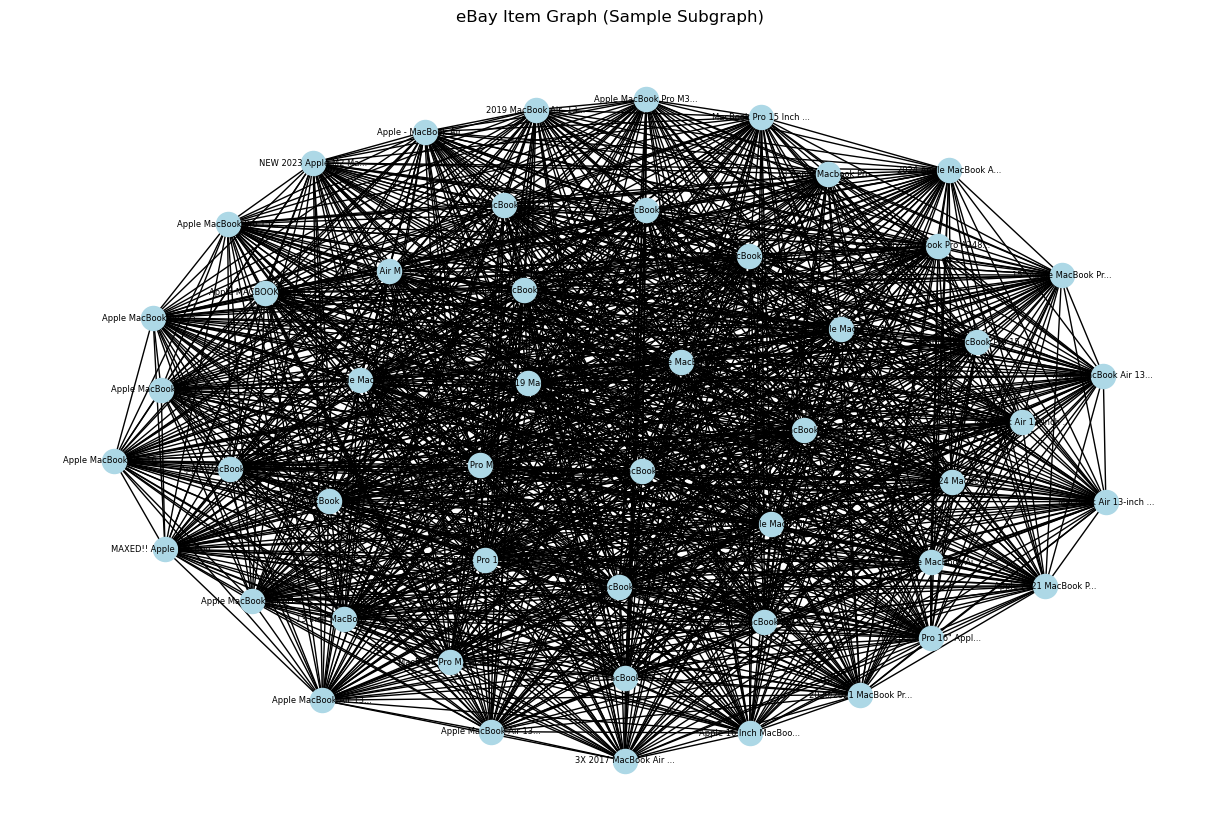

In [32]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Load the graph
graph_data = torch.load("ebay_graph_full.pt",weights_only=False)
data = graph_data["data"]

# Convert to NetworkX
G = to_networkx(data, to_undirected=True)

# Optional: Add labels from titles
titles = graph_data["titles"]
# Create label dict only for nodes in the subgraph
label_dict = {i: titles[i][:20] + "..." for i in subgraph.nodes}

# Plot a small subgraph for readability
sub_nodes = list(G.nodes)[:50]
subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color='lightblue', with_labels=True, labels=label_dict, font_size=6)
plt.title("eBay Item Graph (Sample Subgraph)")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

# Step 1: Load the densified graph
graph_info = torch.load("ebay_graph_semantic.pt", weights_only=False)
data = graph_info['data']
id2idx = graph_info['id2idx']
idx2id = graph_info['idx2id']

# Step 2: Define a lightweight GAT model
class ItemGNN(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden, heads=4)
        self.conv2 = GATConv(hidden * 4, hidden, heads=4)
        self.conv3 = GATConv(hidden * 4, hidden, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        return self.conv3(x, edge_index)


# Step 3: Train the model
model = ItemGNN(data.num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

print("🚀 Training GNN on densified graph...")
for epoch in range(5):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = (out.norm(dim=1) ** 2).mean()  # dummy objective
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Step 4: Save embeddings
model.eval()
with torch.no_grad():
    embs = model(data.x, data.edge_index)
    torch.save(embs, "ebay_item_embeddings.pt")
    print("✅ Saved item embeddings to ebay_item_embeddings.pt")


In [42]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load the saved graph
graph_data = torch.load("ebay_graph_full.pt", weights_only=False)
data = graph_data["data"]
titles = graph_data["titles"]
image_urls = graph_data["image_urls"]
id2idx = graph_data["id2idx"]
idx2id = graph_data["idx2id"]

# Re-encode titles if needed
embedder = SentenceTransformer("all-MiniLM-L6-v2")
title_embs = embedder.encode(titles, convert_to_numpy=True)

# Build sparse adjacency list
edge_list = data.edge_index.t().tolist()
adj = {i: set() for i in range(data.num_nodes)}
for src, dst in edge_list:
    adj[src].add(dst)

# Prune edges: top-K most similar neighbors based on title embeddings
k = 10
pruned_edges = []

for src, neighbors in adj.items():
    if not neighbors:
        continue

    dst_list = list(neighbors)
    src_emb = title_embs[src].reshape(1, -1)
    dst_embs = title_embs[dst_list]
    sims = cosine_similarity(src_emb, dst_embs).flatten()

    topk_indices = np.argsort(sims)[::-1][:k]
    for idx in topk_indices:
        pruned_edges.append([src, dst_list[idx]])

# Build new edge_index
new_edge_index = torch.tensor(pruned_edges, dtype=torch.long).t().contiguous()
data.edge_index = new_edge_index

# Save updated graph
torch.save({
    "data": data,
    "id2idx": id2idx,
    "idx2id": idx2id,
    "titles": titles,
    "image_urls": image_urls
}, "ebay_graph_pruned.pt")

print(f"Graph pruned and saved: {data.num_nodes} nodes, {data.edge_index.shape[1]} edges.")


Graph pruned and saved: 8963 nodes, 88878 edges.


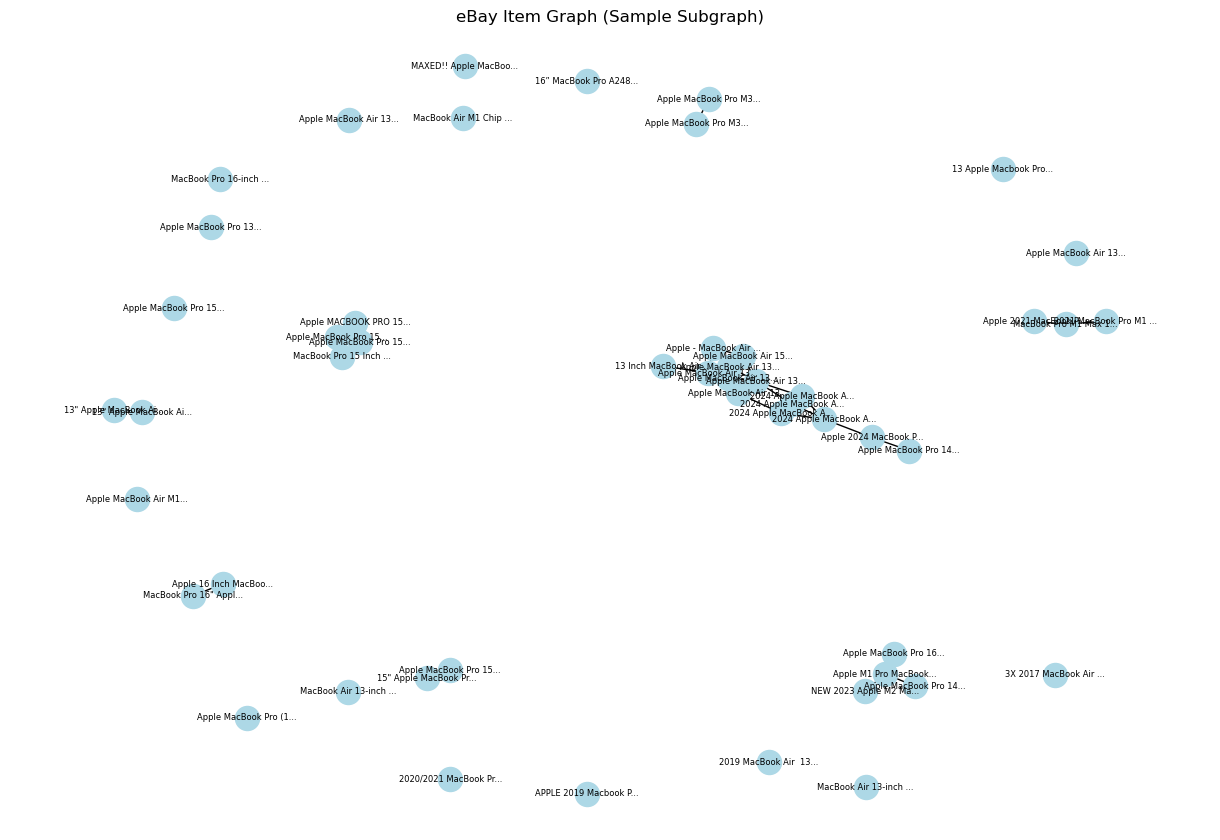

In [43]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Load the graph
graph_data = torch.load("ebay_graph_pruned.pt",weights_only=False)
data = graph_data["data"]

# Convert to NetworkX
G = to_networkx(data, to_undirected=True)

# Optional: Add labels from titles
titles = graph_data["titles"]
# Create label dict only for nodes in the subgraph
label_dict = {i: titles[i][:20] + "..." for i in subgraph.nodes}

# Plot a small subgraph for readability
sub_nodes = list(G.nodes)[:50]
subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color='lightblue', with_labels=True, labels=label_dict, font_size=6)
plt.title("eBay Item Graph (Sample Subgraph)")
plt.show()


In [44]:
deg = torch.bincount(data.edge_index[0])
print(f"Average node degree: {deg.float().mean():.2f}")
print(f"Number of isolated nodes: {(deg == 0).sum().item()}")

Average node degree: 9.92
Number of isolated nodes: 27


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv

# Load graph data
graph_data = torch.load("ebay_graph_pruned.pt",weights_only=False)
data = graph_data["data"]
x = data.x
edge_index = data.edge_index

# Define GraphSAGE model
class GraphSAGEModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Model configuration
in_dim = x.size(1)
hidden_dim = 64
out_dim = 64

model = GraphSAGEModel(in_dim, hidden_dim, out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Dummy unsupervised loss (unit norm regularization)
print("Training GraphSAGE model...")
model.train()
for epoch in range(20):  # Increase epochs as needed
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = (out.norm(dim=1) ** 2).mean()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")

# Save final embeddings
model.eval()
with torch.no_grad():
    embeddings = model(x, edge_index)
    torch.save(embeddings, "ebay_item_embeddings_sage.pt")
    print("Saved node embeddings to 'ebay_item_embeddings_sage.pt'")


Training GraphSAGE model...
Epoch 1: Loss = 8.0053
Epoch 2: Loss = 19.5502
Epoch 3: Loss = 11.2440
Epoch 4: Loss = 7.2317
Epoch 5: Loss = 5.5665
Epoch 6: Loss = 4.3789
Epoch 7: Loss = 3.8086
Epoch 8: Loss = 3.1916
Epoch 9: Loss = 2.8344
Epoch 10: Loss = 2.4331
Epoch 11: Loss = 2.0906
Epoch 12: Loss = 1.8139
Epoch 13: Loss = 1.6701
Epoch 14: Loss = 1.6190
Epoch 15: Loss = 1.3866
Epoch 16: Loss = 1.2042
Epoch 17: Loss = 1.1580
Epoch 18: Loss = 1.0865
Epoch 19: Loss = 0.9876
Epoch 20: Loss = 0.8651
Saved node embeddings to 'ebay_item_embeddings_sage.pt'


In [48]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Load embeddings and metadata
embs = torch.load("ebay_item_embeddings_sage.pt").numpy()
df = pd.read_csv("preprocessed_ebay_features.csv")
titles = df["title"].tolist()
image_urls = df["image_url"].tolist()

# Cosine similarity matrix
sim_matrix = cosine_similarity(embs)

# Recommend top-K similar items
def recommend(item_index, k=5):
    sims = sim_matrix[item_index]
    top_k = np.argsort(sims)[::-1][1:k+1]  # skip self
    return top_k

# Example: test for item 42
item_id = 42
top_indices = recommend(item_id)

print(f"Item: {titles[item_id]}")
print("\nRecommended:")
for idx in top_indices:
    print(f" - {titles[idx]} (Image: {image_urls[idx]})")


Item: Apple MacBook Air 13-inch M2 Chip 16GB RAM 256GB SSD Midnight MC7X4LL/A

Recommended:
 - Apple MacBook Air 13" M2 chip 16GB RAM 256GB SSD Silver MC7V4LL/A 2022 Model (Image: https://i.ebayimg.com/images/g/EL8AAOSwC1dn0662/s-l225.jpg)
 - Apple MacBook Air 13" M4 Chip 24GB RAM 512GB SSD Midnight MC6C4LL/A 2025 Model (Image: https://i.ebayimg.com/images/g/w38AAOSwBm9oAdSh/s-l225.jpg)
 - Apple MacBook Air 13" M2 chip 16GB RAM 256GB SSD Midnight MC7X4LL/A 2022 Model (Image: https://i.ebayimg.com/images/g/GRgAAOSw5H5nZ2dO/s-l225.jpg)
 - Apple MacBook Air 13" M4 chip 16GB RAM 512GB SSD Midnight MW133LL/A 2025 Model (Image: https://i.ebayimg.com/images/g/p8sAAOSwRn1n9eWR/s-l225.jpg)
 - Apple MacBook Pro MPXQ2LL/A Intel Core i5-7360U @ 2.3 GHz 8GB RAM 256GB SSD **** (Image: https://i.ebayimg.com/images/g/wM0AAOSwWodngWxM/s-l225.jpg)


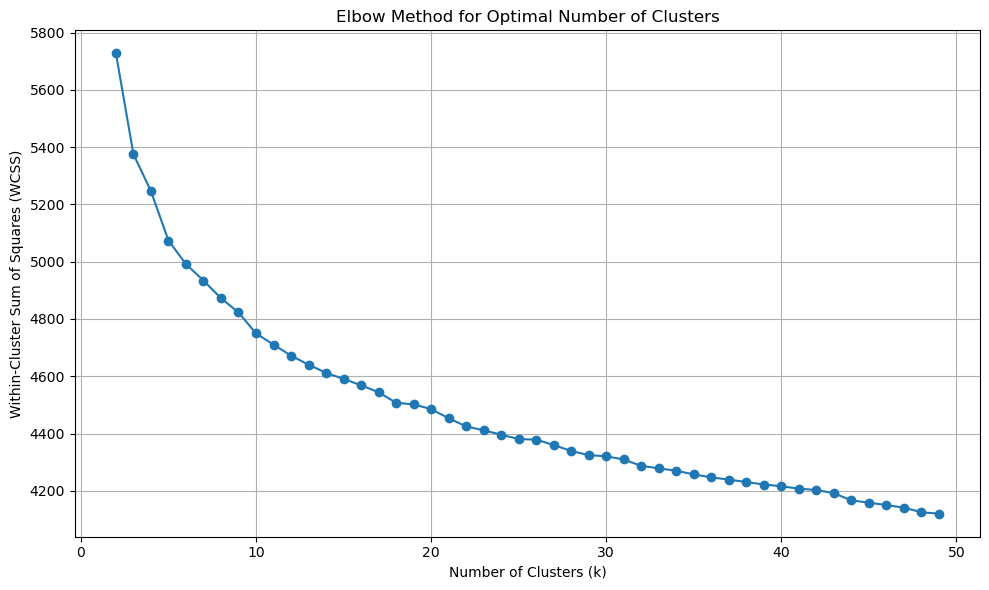

In [57]:
import torch
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load data
embeddings = torch.load("ebay_item_embeddings_sage.pt", map_location="cpu").numpy()
df = pd.read_csv("preprocessed_ebay_features.csv")

# Elbow method
wcss = []
k_range = range(2, 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(embeddings)
    wcss.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
import torch
import json
import pandas as pd
from sklearn.cluster import KMeans



# Step 1: Load GNN embeddings
embeddings = torch.load("ebay_item_embeddings_sage.pt", map_location="cpu").numpy()

# Step 2: Perform KMeans clustering
k = 15  # based on elbow method
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(embeddings)
cluster_labels = kmeans.labels_

# Step 3: Load original JSONL data (with all fields)
with open("combined.jsonl") as f:
    rich_items = [json.loads(line) for line in f]

# Sanity check
assert len(rich_items) == len(cluster_labels), "Mismatch between item and embedding count!"
flattened_items = []

for i, item in enumerate(rich_items):
    flat = {
        "itemId": item.get("itemId"),
        "title": item.get("title", ""),
        "price_value": item.get("price", {}).get("value", ""),
        "price_currency": item.get("price", {}).get("currency", ""),
        "image_url": item.get("image", {}).get("imageUrl", ""),
        "condition": item.get("condition", ""),
        "category_name": item.get("categoryName", ""),
        "seller_username": item.get("seller", {}).get("username", ""),
        "location": item.get("itemLocation", {}).get("postalCode", ""),
        "shortDescription": item.get("shortDescription") or item.get("subtitle", ""),
        "cluster_id": int(cluster_labels[i])
    }
    flattened_items.append(flat)

# Step 5: Save to enriched CSV (or JSONL if needed)
df = pd.DataFrame(flattened_items)
df.to_csv("ebay_clustered_items.csv", index=False)


print("Clustered data saved to ebay_clustered_items.csv")


Clustered data saved to ebay_clustered_items.csv


In [69]:
df.head()

itemId                                              title  \
0  v1|226736633219|0  Apple 16 Inch MacBook Pro 2019/2021 32GB RAM 5...   
1  v1|234702350191|0  Apple MacBook Pro 15" 16GB i7 3.7Ghz - Retina ...   
2  v1|234725338124|0  13" Apple MacBook Air 512gb SSD 8gb 3.2Ghz i7 ...   
3  v1|232090380033|0  13" Apple MacBook Air Big Sur 3.3Ghz i7 TURBO ...   
4  v1|127133794717|0  Apple - MacBook Air 15inch Apple M4 chip  - 16...   

  price_value price_currency  \
0      725.00            USD   
1      475.00            USD   
2      329.00            USD   
3      319.00            USD   
4      750.00            USD   

                                           image_url                condition  \
0  https://i.ebayimg.com/images/g/wmgAAOSw87FoJ4H...  Very Good - Refurbished   
1  https://i.ebayimg.com/images/g/58AAAOSwMWVjKdl...                     Used   
2  https://i.ebayimg.com/images/g/eWMAAOSw1ipjQES...                     Used   
3  https://i.ebayimg.com/images/g/aY0AAOSwJmZhQQU...                     Used   
4  https://i.ebayimg.com/images/g/g3AAAeSw3S1oMpu...                      New   

  category_name   seller_username location shortDescription  cluster_id  
0                alpha_tech_store    551**                            9  
1                   payless4apple    841**                            9  
2                   payless4apple    841**                            9  
3                   payless4apple    841**                            9  
4                       blissco25    935**                            9